In [1]:
import pandas as pd

In [2]:
from tqdm.auto import tqdm
tqdm.pandas()

/home/vscode/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_json('wish_queries_with_timestamp.json', lines=True)

In [4]:
df['min_timestamp_datetime'] = pd.to_datetime(df['min_timestamp'], unit='s')
df.set_index('min_timestamp_datetime', inplace=True)
df = df.sort_index()

In [7]:
df

,query,min_timestamp,max_timestamp,min_dt,max_dt,cnt,gmv
min_timestamp_datetime,,,,,,,
2019-12-31 08:00:00,posters elefantes,1577779200,1655259026,2020-01-01,2022-06-15,145,0.000000e+00
2019-12-31 08:00:00,ben 10 toys,1577779200,1669795184,2020-01-01,2022-11-30,26952,2.796466e+03
2019-12-31 08:00:00,cover iphone 11 pro max,1577779200,1669794442,2020-01-01,2022-11-30,222735,1.558650e+04
2019-12-31 08:00:00,king and queen,1577779200,1669794566,2020-01-01,2022-11-30,717750,1.311209e+05
2019-12-31 08:00:00,electric bike,1577779200,1669795158,2020-01-01,2022-11-30,4111706,1.056199e+06
...,...,...,...,...,...,...,...
2022-11-30 07:59:56,moxa cone needld,1669795196,1669795196,2022-11-30,2022-11-30,1,0.000000e+00
2022-11-30 07:59:57,scheerapparaat heren mesjes philips 1000,1669795197,1669795198,2022-11-30,2022-11-30,2,0.000000e+00
2022-11-30 07:59:58,golden diamond krone handyhülle,1669795198,1669795198,2022-11-30,2022-11-30,1,0.000000e+00


In [8]:
from dateutil.relativedelta import relativedelta
import numpy as np

# analyze with head queries caching

In [10]:
from tahoe import execute_async
latest_head_queries_table = execute_async("""
        SELECT DISTINCT (table_name) FROM information_schema.tables 
        WHERE table_schema = 'search'
        AND table_name like 'query_join_v2_%'
        """)

In [11]:
latest_head_queries_table

[('query_join_v2_20230201140054',),
 ('query_join_v2_20230125140116',),
 ('query_join_v2_20230111140050',),
 ('query_join_v2_20230104140046',)]

In [18]:
head_queries = []
for i in tqdm(latest_head_queries_table):
    res = execute_async(f"""
        SELECT query FROM search.{i[0]}
        """)
    head_queries += res
head_queries = set([i[0] for i in head_queries])

100%|██████████| 4/4 [04:50<00:00, 72.53s/it]


In [19]:
len(head_queries)

6316939

### past 1 year

In [23]:
df_since2022 = df.loc['2021-11-30':'2022-11-30']

In [27]:
df_head_2023jan = pd.DataFrame({'query': list(head_queries)})

In [29]:
df_head_2023jan['is_head'] = True

In [31]:
df_since2022_merge = df_since2022.merge(df_head_2023jan, on='query', how='left')

In [36]:
len(df_since2022_merge), len(df_since2022)

(100207554, 100207554)

In [37]:
df_since2022_merge_tail = df_since2022_merge[df_since2022_merge.is_head.isna()]

In [39]:
df_since2022_merge_tail.gmv.max(), df_since2022_merge_tail.gmv.mean(), df_since2022_merge_tail.gmv.median()

(27714.681640625, 0.3393399830142919, 0.0)

In [41]:
df_since2022_merge_tail['min_timestamp_datetime'] = pd.to_datetime(df_since2022_merge_tail['min_timestamp'], unit='s')
df_since2022_merge_tail.set_index('min_timestamp_datetime', inplace=True)
df_since2022_merge_tail = df_since2022_merge_tail.sort_index()

/tmp/ipykernel_121749/2643443030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_since2022_merge_tail['min_timestamp_datetime'] = pd.to_datetime(df_since2022_merge_tail['min_timestamp'], unit='s')


In [43]:
df_since2022_merge_tail_roll_s_count = df_since2022_merge_tail.rolling(window='1S')['query'].count()

<AxesSubplot: xlabel='min_timestamp_datetime'>

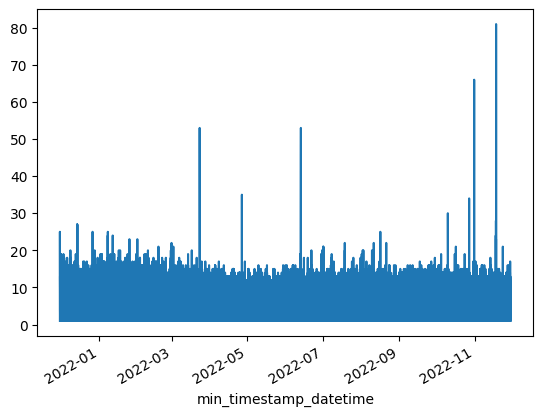

In [44]:
df_since2022_merge_tail_roll_s_count.plot()

In [64]:
df_since2022_merge_tail_roll_s_count_max = df_since2022_merge_tail_roll_s_count.groupby('min_timestamp_datetime').max()

In [65]:
df_since2022_merge_tail_roll_s_count_max.mean(), df_since2022_merge_tail_roll_s_count_max.median(), \
    df_since2022_merge_tail_roll_s_count_max.max()

(3.382267622296773, 3.0, 81.0)

In [69]:
df_since2022_merge_tail_roll_s_count_max[df_since2022_merge_tail_roll_s_count_max > 20].sum() / df_since2022_merge_tail_roll_s_count_max.sum()

2.1497324748889087e-05

In [74]:
df_since2022_merge_tail_roll_s_count_max[df_since2022_merge_tail_roll_s_count_max > 15].sum() / df_since2022_merge_tail_roll_s_count_max.sum()

0.0002498071547257537

In [72]:
df_since2022_merge_tail_roll_s_count_max[df_since2022_merge_tail_roll_s_count_max > 10].sum() / df_since2022_merge_tail_roll_s_count_max.sum()

0.00981835785705059

In [76]:
df_since2022_merge_tail_roll_s_count_max[df_since2022_merge_tail_roll_s_count_max > 5].sum() / df_since2022_merge_tail_roll_s_count_max.sum()

0.27371508434715064

### past 1 month

In [45]:
# time range needs to line up with latest_head_queries_table min and max date for analysis to be valid
latest_head_queries_records = execute_async("""SELECT query, MIN(timestamp) as min_timestamp, MAX(timestamp) as max_timestamp,
    MIN(dt) as min_dt, MAX(dt) as max_dt, COUNT(request_id) as cnt, SUM(gmv) as gmv
    FROM search.search_queries 
    WHERE dt >='2023-01-04' and dt <= '2023-02-01'
    GROUP BY query ORDER BY min_timestamp""")

In [47]:
df_latest_1month_queries = pd.DataFrame(latest_head_queries_records)

In [49]:
df_latest_1month_queries.columns = ['query', 'min_timestamp', 'max_timestamp', 'min_dt', 'max_dt', 'cnt', 'gmv']

In [51]:
df_latest_1month_queries_merge = df_latest_1month_queries.merge(df_head_2023jan, on='query', how='left')

In [52]:
len(df_latest_1month_queries_merge), len(df_latest_1month_queries)

(15707164, 15707164)

In [53]:
df_latest_1month_queries_merge_tail = df_latest_1month_queries_merge[df_latest_1month_queries_merge.is_head.isna()]

In [54]:
df_latest_1month_queries_merge_tail.gmv.max(), df_latest_1month_queries_merge_tail.gmv.mean(), df_latest_1month_queries_merge_tail.gmv.median()

(1485.082779174223, 0.2838827598759887, 0.0)

In [55]:
df_latest_1month_queries_merge_tail['min_timestamp_datetime'] = pd.to_datetime(df_latest_1month_queries_merge_tail['min_timestamp'], unit='s')
df_latest_1month_queries_merge_tail.set_index('min_timestamp_datetime', inplace=True)
df_latest_1month_queries_merge_tail = df_latest_1month_queries_merge_tail.sort_index()

/tmp/ipykernel_121749/494453702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_latest_1month_queries_merge_tail['min_timestamp_datetime'] = pd.to_datetime(df_latest_1month_queries_merge_tail['min_timestamp'], unit='s')


In [56]:
df_latest_1month_queries_merge_tail_roll_s_count = df_latest_1month_queries_merge_tail.rolling(window='1S')['query'].count()

<AxesSubplot: xlabel='min_timestamp_datetime'>

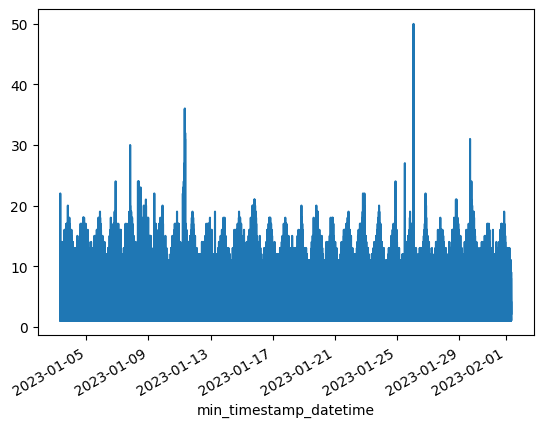

In [57]:
df_latest_1month_queries_merge_tail_roll_s_count.plot()

In [60]:
df_latest_1month_queries_merge_tail_roll_s_count_max = df_latest_1month_queries_merge_tail_roll_s_count.groupby('min_timestamp_datetime').max()

In [63]:
df_latest_1month_queries_merge_tail_roll_s_count_max.mean(), df_latest_1month_queries_merge_tail_roll_s_count_max.median(), \
    df_latest_1month_queries_merge_tail_roll_s_count_max.max()

(4.866240934981742, 5.0, 50.0)

In [70]:
df_latest_1month_queries_merge_tail_roll_s_count_max[df_latest_1month_queries_merge_tail_roll_s_count_max > 20].sum() / df_latest_1month_queries_merge_tail_roll_s_count_max.sum()

8.45247868937566e-05

In [73]:
df_latest_1month_queries_merge_tail_roll_s_count_max[df_latest_1month_queries_merge_tail_roll_s_count_max > 15].sum() / df_latest_1month_queries_merge_tail_roll_s_count_max.sum()

0.0023313503351524503

In [71]:
df_latest_1month_queries_merge_tail_roll_s_count_max[df_latest_1month_queries_merge_tail_roll_s_count_max > 10].sum() / df_latest_1month_queries_merge_tail_roll_s_count_max.sum()

0.06700248181112445

In [75]:
df_latest_1month_queries_merge_tail_roll_s_count_max[df_latest_1month_queries_merge_tail_roll_s_count_max > 5].sum() / df_latest_1month_queries_merge_tail_roll_s_count_max.sum()

0.5549581581465431

# analyze without head queries caching

In [ ]:
df_roll_s_count = df.rolling(window='1S')['query'].count()

<AxesSubplot: xlabel='min_timestamp_datetime'>

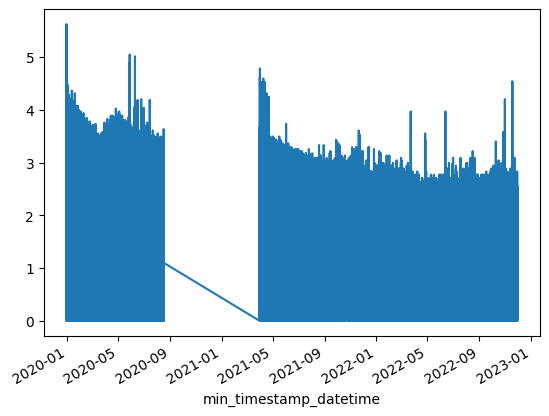

In [ ]:
df_roll_s_count.apply(lambda x: np.log(x)).plot()

In [ ]:
df_roll_s_count.mean(), df_roll_s_count.median()

(7.1596399716499715, 5.0)

In [ ]:
df_roll_s_count_gmvnonzero = df[df.gmv > 0].rolling(window='1S')['query'].count()
df_roll_s_count_cntgt100 = df[df.cnt > 100].rolling(window='1S')['query'].count()

<AxesSubplot: xlabel='min_timestamp_datetime'>

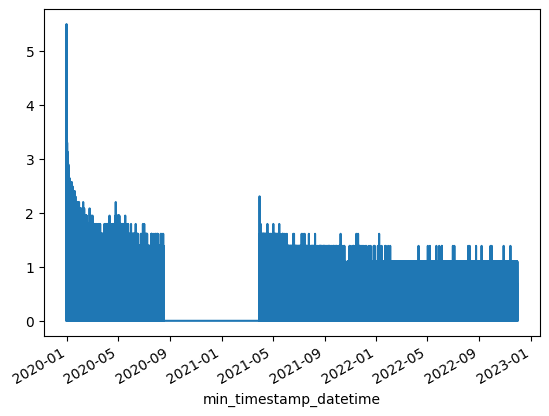

In [ ]:
df_roll_s_count_gmvnonzero.apply(lambda x: np.log(x)).plot()

<AxesSubplot: xlabel='min_timestamp_datetime'>

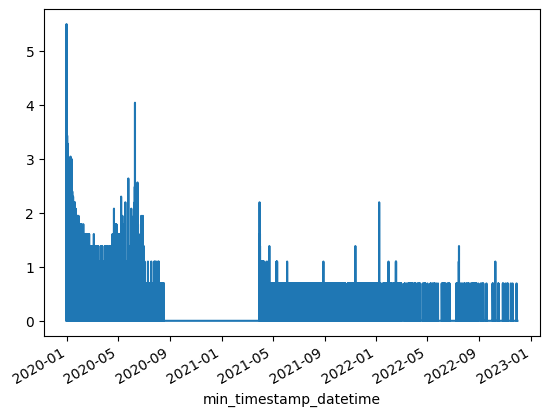

In [ ]:
df_roll_s_count_cntgt100.apply(lambda x: np.log(x)).plot()

In [ ]:
df_roll_s_count_gmvnonzero.mean(), df_roll_s_count_gmvnonzero.median()

(2.059954738078277, 1.0)

In [ ]:
df_roll_s_count_cntgt100.mean(), df_roll_s_count_cntgt100.median()

(3.53423154239845, 2.0)

In [ ]:
np.exp(6) / (1/0.14) * .316 * 9000, np.exp(2) / (1/0.14) * .316 * 9000

(160629.20841706742, 2942.026576350228)

In [ ]:
1 / .14

7.142857142857142

In [ ]:
df.gmv.sum() / 3

600390043.5127572

In [ ]:
160629 / 600390043

0.00026754107912479156

In [ ]:
df.cnt.sum() / 3

7165963371.0

In [ ]:
600390043.5127572 / 7165963371.0

0.08378357694967865

In [ ]:
df.cnt.sum() / len(df)

40.631052944622944

<AxesSubplot: ylabel='Frequency'>

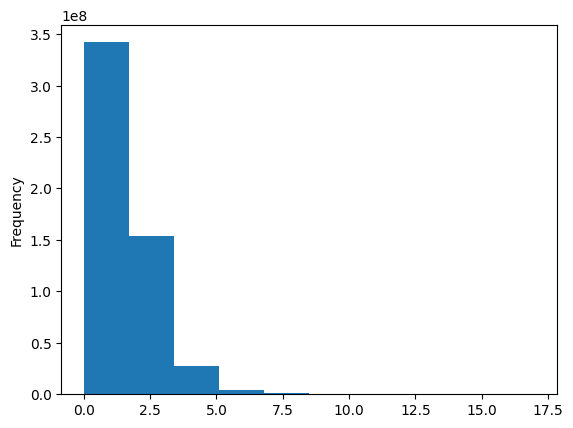

In [ ]:
df.cnt.apply(np.log).plot.hist()

<AxesSubplot: ylabel='Frequency'>

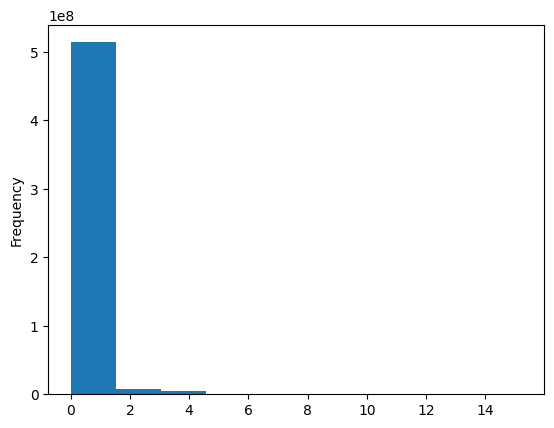

In [ ]:
df.gmv.apply(lambda x: np.log(x + 1)).plot.hist()

In [ ]:
df_roll_s_count_max = df_roll_s_count.groupby('min_timestamp_datetime').max()

In [ ]:
df_roll_s_count_max.max(), df_roll_s_count_max.min(), df_roll_s_count_max.mean(), df_roll_s_count_max.median()

(278.0, 1.0, 7.629152423227022, 5.0)

<AxesSubplot: xlabel='min_timestamp_datetime'>

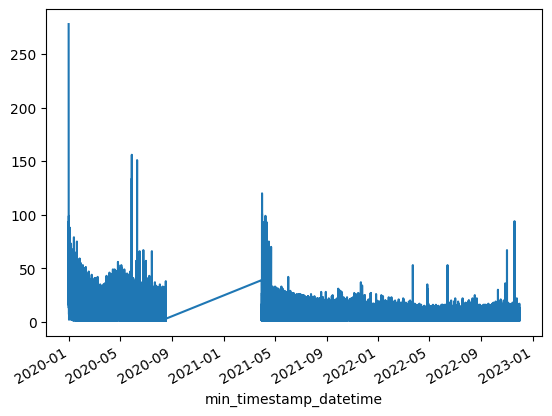

In [ ]:
df_roll_s_count_max.plot.line()

In [ ]:
(df.gmv == 0).mean()

0.9657667794367795

In [ ]:
(df.cnt <= 100).mean()

0.9824899187299188

In [ ]:
((df.cnt <= 100) & (df.gmv == 0)).mean()

0.9572420846720847

In [ ]:
df_0gmv_highcnt = df[df.gmv == 0].sort_values('cnt', ascending=False)

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
tmp = df_0gmv_highcnt.head(10000)

In [ ]:
tmp[tmp['query'].str.count(' ') >= 1].head(500)

,query,min_timestamp,max_timestamp,min_dt,max_dt,cnt,gmv
min_timestamp_datetime,,,,,,,
2020-04-13 00:28:15,dillo for women,1586737695,1669794428,2020-04-13,2022-11-30,63472,0.0
2019-12-31 20:20:21,package hip dress,1577823621,1669744808,2020-01-01,2022-11-30,55374,0.0
2019-12-31 20:47:47,full length,1577825267,1668789258,2020-01-01,2022-11-19,50324,0.0
2020-04-22 11:31:56,pornography and depression,1587555116,1669794616,2020-04-23,2022-11-30,48410,0.0
2019-12-31 20:22:25,round collar,1577823745,1669003253,2020-01-01,2022-11-21,47798,0.0
2019-12-31 19:53:20,v neckdress,1577822000,1669687694,2020-01-01,2022-11-29,45390,0.0
2019-12-31 20:27:10,sleeve lace,1577824030,1667953556,2020-01-01,2022-11-09,43974,0.0
2019-12-31 23:31:16,soild color,1577835076,1669659945,2020-01-01,2022-11-29,41820,0.0
2020-04-21 11:28:08,บุหรี่ไฟฟ้า ราคาไม่เกิน 500,1587468488,1669133694,2020-04-22,2022-11-23,39914,0.0


In [ ]:
df[df['query'] == 'dildo']

,query,min_timestamp,max_timestamp,min_dt,max_dt,cnt,gmv
min_timestamp_datetime,,,,,,,
2019-12-31 08:00:01,dildo,1577779201,1669795198,2020-01-01,2022-11-30,22271003,685304.3125


In [ ]:
685304.3125 / 22271003

0.030771147240202877

In [ ]:
df['gmv_per_cnt'] = df['gmv'] / df['cnt']

<AxesSubplot: ylabel='Frequency'>

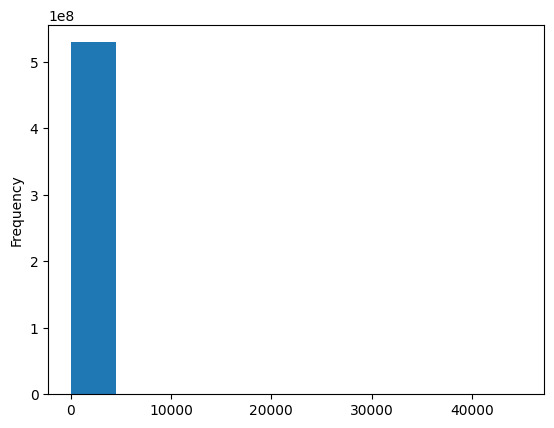

In [ ]:
df.gmv_per_cnt.plot.hist()

<AxesSubplot: ylabel='Frequency'>

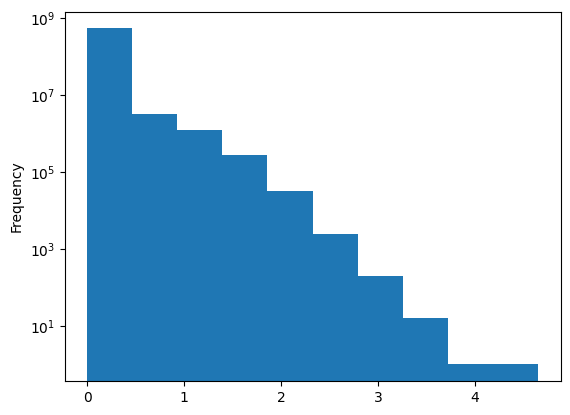

In [ ]:
df.gmv_per_cnt.apply(lambda x: np.log10(x + 1)).plot.hist(log=True)